# setup and load data

In [1]:
import keras
import pandas as pd
import numpy as np
from tensorflow.python.client import device_lib
import math
import dateutil.parser
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
print(device_lib.list_local_devices())
data = pd.read_csv(r'C:\Users\Ido\Desktop\datasets\patient_no_show\noshowdata.csv')


Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7903182312032263659
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1503651430
locality {
  bus_id: 1
}
incarnation: 10477924967027422044
physical_device_desc: "device: 0, name: GeForce 940M, pci bus id: 0000:06:00.0, compute capability: 5.0"
]


# Preprocessing

In [2]:
#First, let's look at the data. Most features are binary coded.
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [3]:
data['PatientId'] = data.apply(lambda x:str(x['PatientId']),axis=1)
data[:5]
#Age, Gender, ScheduledDay and AppointmentDay, Neighbourhood all need some work to extract valuable information

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.0,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438.0,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951.0,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174.0,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183.0,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
#Let's make the No-show and Gender factors binary
data['no_show'] = data.apply(lambda x:int(x['No-show']=='Yes'),axis=1)
data['is_male'] = data.apply(lambda x:int(x['Gender']=='M'),axis=1)


#And drop the original columns
data = data.drop(columns=['Gender'],axis=0)
data = data.drop(columns=['No-show'],axis=0)

## Age 

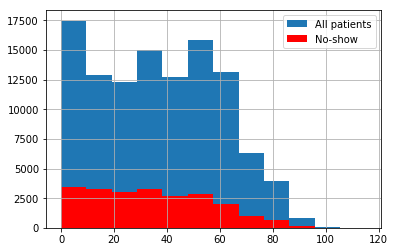

<Figure size 432x288 with 0 Axes>

In [5]:
data = data[data['Age']>=0]
#Let's look at how the ages are distributed
ax = pd.Series(data['Age']).hist(bins=12)
ax2 = pd.Series(data[['Age','no_show']][data['no_show']==1]['Age']).hist(bins=12,color='red')
ax.legend(['All patients','No-show'])
plt.figure()
plt.show()


Most patients are younger than 60, other than that the data is balanced in terms of age.
Let's look the outliers




In [6]:
data[data['Age']>data['Age'].quantile(0.999)].describe()



,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,no_show,is_male
count,1.030000e+02,103.000000,103.0,103.000000,103.000000,103.0,103.000000,103.000000,103.000000,103.000000
mean,5.664662e+06,96.572816,0.0,0.611650,0.145631,0.0,0.213592,0.213592,0.184466,0.300971
std,1.000629e+05,4.545202,0.0,0.489758,0.354461,0.0,0.456983,0.411846,0.389760,0.460923
min,5.284772e+06,94.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,5.626168e+06,94.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,5.681315e+06,95.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,5.729392e+06,97.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
max,5.789013e+06,115.000000,0.0,1.000000,1.000000,0.0,2.000000,1.000000,1.000000,1.000000


These look like legitimate data, nevertheless they won't give enough information to be valueable.
I'll remove ages over 100


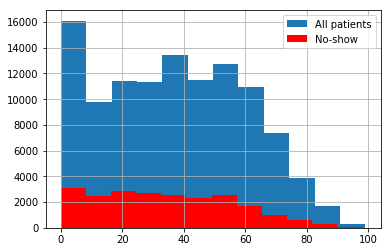

<Figure size 432x288 with 0 Axes>

In [7]:
data = data[data['Age']<100]
ax = pd.Series(data['Age']).hist(bins=12)
pd.Series(data[['Age','no_show']][data['no_show']==1]['Age']).hist(bins=12,color='red')
ax.legend(['All patients','No-show'])
ax.xlabel='Age'
plt.figure()
plt.show()

These functions will help me split continuous data into regions and graph their no_show rate

In [8]:
import numpy as np

#get_splits quantizes the data into bins
def get_splits(data, column, bins, method, base = 0.5):
    if (method == 'linear'):
        splits = np.linspace(data[column].min(),data[column].max(),bins+1)[:-1]
    if (method == 'quantile'):
        splits = data[column].quantile(np.linspace(0,1,bins+1)[:-1])
    if (method == 'pow'):
        splits = np.power(data[column].min()+ np.linspace(0,1,bins+1)[:-1], base)*data[column].max()
    if (method == 'pow-quantile'):
        splits = data[column].quantile(np.power(np.linspace(0,1,bins+1)[:-1], base))
    return splits

def analyze_splits(data, column, bins = 10, method = 'linear', base = 0.5):
    new_data =pd.DataFrame(data[[column,'no_show']])
    splits = get_splits(data,column,bins,method, base)
    
    new_data['code'] = np.digitize(data[column], splits)
    data_means = pd.DataFrame(pd.DataFrame(new_data).groupby('code').mean()) 

    plt.stem(data_means[column],data_means['no_show'])
    
    plt.ylabel('no_show')
    plt.xlabel('column')
    plt.show()
    return (splits,data_means)
    
#

Let's try to see how the no_show probability changes with the age

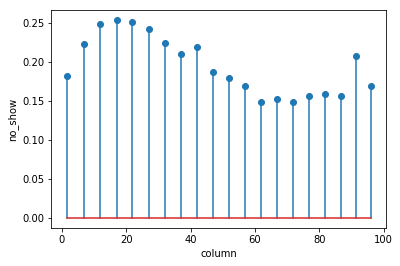

splits:
 [  0.     4.95   9.9   14.85  19.8   24.75  29.7   34.65  39.6   44.55
  49.5   54.45  59.4   64.35  69.3   74.25  79.2   84.15  89.1   94.05]


means:
             Age   no_show
code                     
1      1.488381  0.182093
2      6.954238  0.223835
3     11.930128  0.249395
4     17.105256  0.253704
5     21.928092  0.251604
6     27.044863  0.241853
7     32.012641  0.224884
8     37.047675  0.210293
9     42.024522  0.219822
10    47.045800  0.186736
11    51.989885  0.179845
12    57.029912  0.169933
13    61.980948  0.149018
14    66.860333  0.152987
15    71.936328  0.149063
16    76.868636  0.155849
17    81.712656  0.158714
18    86.667976  0.156189
19    91.524496  0.207493
20    96.033898  0.169492


In [9]:

splits, means = analyze_splits(data,'Age',bins = 20, method='linear')
print('splits:\n',splits)
print('\n\nmeans:\n',means)

This doesn't give enough importance to young ages, we could skew quantization towards lower ages by splitting with power base
We also have more information for younger ages, so it makes sense to split it more often than sparse information

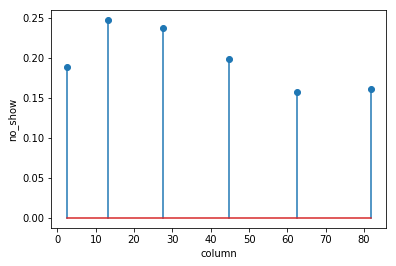

splits:
 [  0.           6.73609679  19.05255888  35.00178567  53.88877434
  75.31185166]


means:
             Age   no_show
code                     
1      2.400770  0.188726
2     13.117315  0.247101
3     27.629780  0.237208
4     44.647576  0.199195
5     62.572984  0.157897
6     81.802267  0.161122


In [10]:
splits, means = analyze_splits(data,'Age',bins = 6, method= 'pow', base = 1.5)
print('splits:\n',splits)
print('\n\nmeans:\n',means)
#Age data is obviously significant. Young adults miss more appointments.

#We'd like to later split more often where there's more variance (ages 0-20 for example)


I could choose to simply code the ages according to the groups, and I'll try to do that.
But this will cause information loss because although group 5 should be similar to group 6 and 4, the model doesn't reflect that.

I could solve this by coding each of the age groups with its adjacent neighbours.

for example: a 26 year old is 20-30 but also a little 10-20 and a little 30-40


I could also pick significant points on the graph and calculate the proximity to each point

for example: ages 0, 23 and 70 are peaks. Coding for the proximity could give me the influence each age group has on the patient. A 40 year old will be similar to a 23 year old, but also similar to a 70 year old. A simple regression might suffice.


For now, I'll code the ages according to these thresholds (shown in splits) and later I'll decide on how to set the dummy-variables to account for group similarity


In [11]:
splits = get_splits(data,'Age',6,'pow', base = 1.5)
data['age_code'] = np.digitize(data['Age'],splits)
#data = data.drop(columns=['Age'])


## Date

The two time columns are AppointmentDay and ScheduledDay.

1. the appointment day of the week (Sunday - Saturday) will be coded 0-6
2. the scheduling day of the week (Sunday - Saturday) will be coded 0-6
3. Time difference between scheduling and the appointment in days (same day appointments are always -1)


Using the week of the year can give WEEKxDAY interaction, which can differentiate holidays or events.
But this will introduce a lot of complexity, so for now I'll refrain from using it.

In [13]:
seconds_in_day = 24*60*60
time_actions =[{'name': 'app_day_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['AppointmentDay']).weekday())},
              {'name': 'sch_day_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['ScheduledDay']).weekday())},
              #{'name': 'app_week_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['AppointmentDay']).isocalendar()[1])},
              #{'name': 'sch_week_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['ScheduledDay']).isocalendar()[1])},
              #{'name': 'app_year_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['AppointmentDay']).year)},
              #{'name': 'sch_year_code', 'my_lambda' : lambda x:(dateutil.parser.parse(x['ScheduledDay']).year)},
              {'name': 'time_diff', 'my_lambda' : lambda x:(int(math.floor((dateutil.parser.parse(x['AppointmentDay'])\
                                        - dateutil.parser.parse(x['ScheduledDay'])).total_seconds()/seconds_in_day+1)))}]

for action in time_actions:
    data[action['name']] = data.apply(action['my_lambda'],axis=1)
data = data[data['time_diff']>-1]

### Time Difference

Time difference is named 'time_diff' and represents the number of days between scheduling date and appointment date

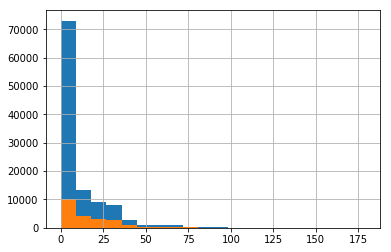

In [14]:
ax = pd.Series(data['time_diff']).hist(bins=20)
ax = pd.Series(data['time_diff'][data['no_show']==1]).hist(bins=20)
plt.show()

Most patients set their appointment on the day or week of the appointment
They also miss the appointment less often.
Let's first try to make sense of the outliers (125+ days)


In [15]:

data[data['time_diff']>100].describe()

,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,no_show,is_male,age_code,app_day_code,sch_day_code,time_diff
count,1.380000e+02,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,5.217599e+06,58.340580,0.072464,0.601449,0.152174,0.021739,0.072464,0.637681,0.297101,0.318841,4.586957,2.115942,1.637681,138.094203
std,7.821621e+04,25.012551,0.260199,0.491383,0.360498,0.146362,0.260199,0.482421,0.458646,0.467725,1.448524,1.250241,1.413914,27.995278
min,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,101.000000
25%,5.140264e+06,45.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.000000,110.000000
50%,5.226171e+06,66.500000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.000000,2.000000,1.000000,133.000000
75%,5.283083e+06,77.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,6.000000,3.000000,3.000000,162.000000
max,5.392234e+06,94.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,4.000000,4.000000,179.000000


In [16]:
test_data = data[data['time_diff']>50]
test_data.describe()

,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,no_show,is_male,age_code,app_day_code,sch_day_code,time_diff
count,3.128000e+03,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000,3128.000000
mean,5.459402e+06,46.316816,0.043478,0.209719,0.070972,0.009910,0.019821,0.637148,0.303389,0.317136,3.970269,1.884910,2.003836,68.692775
std,8.073942e+04,24.031167,0.203964,0.407173,0.256819,0.099073,0.150440,0.480899,0.459795,0.465435,1.440898,1.478831,1.402400,18.947386
min,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,51.000000
25%,5.416665e+06,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,58.000000
50%,5.454654e+06,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,2.000000,2.000000,64.000000
75%,5.530621e+06,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,5.000000,3.000000,3.000000,72.000000
max,5.597360e+06,98.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,6.000000,4.000000,5.000000,179.000000


For 136 patients over 100 days, the no_show rate is 0.301
For 3100 patients over 50 days, the no_show rate is 0.303
With only 136 patients, this doesn't seem like a significant difference,
and these patients probably behave the same. For now I'll remove those outliers.


It seems that patients who schedule 100+ days ahead are older than patients who schedule 50+ days ahead.
This information is found in the model, so we're not missing out on data differentiating those "older, long-ahead appointments"



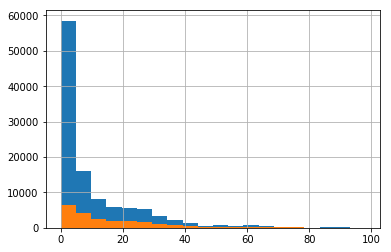

In [17]:
data = data[data['time_diff']<100]
ax = pd.Series(data['time_diff']).hist(bins=20)
ax = pd.Series(data['time_diff'][data['no_show']==1]).hist(bins=20)
plt.show()

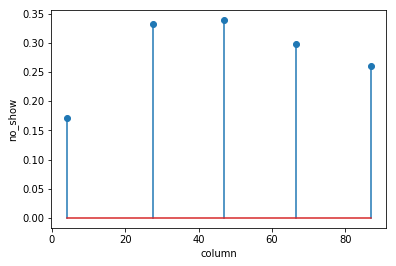

In [18]:
split,mean = analyze_splits(data,column = 'time_diff',bins =5,method = 'linear')


This certainly doesn't give enough attention to earlier days. Let's try a different scale

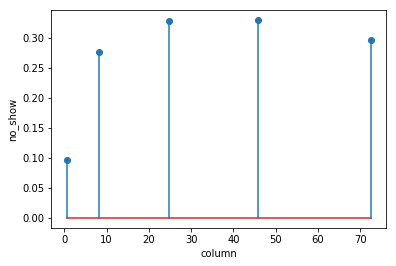

splits:
 [  0.     3.92  15.68  35.28  62.72]


means:
             Age   no_show
code                     
1      2.400770  0.188726
2     13.117315  0.247101
3     27.629780  0.237208
4     44.647576  0.199195
5     62.572984  0.157897
6     81.802267  0.161122


In [244]:
splits,mean = analyze_splits(data,column = 'time_diff',bins = 5,method = 'pow',base=2)
print('splits:\n',splits)
print('\n\nmeans:\n',means)

For better quantization, I could use an iterative algorithm

For now I'll use the given quantization above, but put all the same-day patients in a separate group 

In [243]:

splits = get_splits(data,'time_diff',bins = 5,method = 'pow', base = 2 )
splits = np.insert(splits,1,0.1)
data['time_diff_code'] = np.digitize(data['time_diff'],splits)

### Scheduled Day

Let's look at the no_show rates for each of the days

In [21]:
data.groupby('sch_day_code')['no_show'].describe()

,count,mean,std,min,25%,50%,75%,max
sch_day_code,,,,,,,,
0,23047.0,0.197509,0.398129,0.0,0.0,0.0,0.0,1.0
1,26112.0,0.201976,0.401482,0.0,0.0,0.0,0.0,1.0
2,24251.0,0.200940,0.400712,0.0,0.0,0.0,0.0,1.0
3,18047.0,0.204466,0.403322,0.0,0.0,0.0,0.0,1.0
4,18891.0,0.205389,0.403996,0.0,0.0,0.0,0.0,1.0
5,24.0,0.041667,0.204124,0.0,0.0,0.0,0.0,1.0


Patients are more likely to miss appointments scheduled towards the end of the week


### Appointment Day

In [22]:
data.groupby('app_day_code')['no_show'].describe()

,count,mean,std,min,25%,50%,75%,max
app_day_code,,,,,,,,
0,22687.0,0.206374,0.404711,0.0,0.0,0.0,0.0,1.0
1,25631.0,0.200929,0.400703,0.0,0.0,0.0,0.0,1.0
2,25799.0,0.196480,0.397344,0.0,0.0,0.0,0.0,1.0
3,17223.0,0.193114,0.394753,0.0,0.0,0.0,0.0,1.0
4,18993.0,0.212394,0.409013,0.0,0.0,0.0,0.0,1.0
5,39.0,0.230769,0.426833,0.0,0.0,0.0,0.0,1.0


Patients are more likely to miss appointments during the middle of the week


I'll leave the day codes as they are.  These may interact with the different features to find something more significant

## Neighbourhood

Let's look at the neighbourhoods data

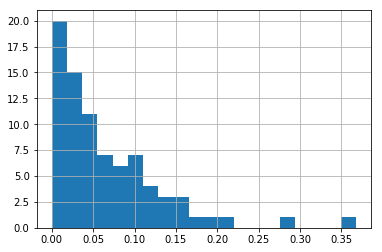

,count,percentage,rate
count,81.000000,81.000000,81.000000
mean,1362.617284,0.064977,0.205205
std,1368.103364,0.065239,0.097108
min,1.000000,0.000048,0.000000
25%,413.000000,0.019694,0.179907
50%,849.000000,0.040485,0.197353
75%,2017.000000,0.096182,0.217049
max,7713.000000,0.367799,1.000000


In [23]:
nei_data = pd.DataFrame
data['Neighbourhood'].unique().size
nei_data = data.groupby('Neighbourhood')['PatientId'].count()
nei_data=nei_data.to_frame()
nei_data['percentage'] = data.groupby('Neighbourhood')['PatientId'].count()/data.size*100
nei_data['rate'] = data.groupby('Neighbourhood')['no_show'].sum()/  data.groupby('Neighbourhood')['no_show'].count()
nei_data = nei_data.sort_values(['percentage'], ascending=[1])

nei_data = nei_data.rename(index = str, columns={'PatientId':'count'})

#nei_data = nei_data[nei_data['count']>100]
nei_data['percentage'].hist(bins=20)
plt.show()

nei_data.describe()


Most of the neighbourhoods have around 1500 patients - 0-0.5% of patients

The no_show rate varies greatly among the most occurent neighbourhoods.
This shows that there is a significant difference between neighbourhoods

Maybe there's a connection between size and no_show rates

In [24]:

def lin_fit(x,y, title = '', legend = ['',''], xlabel='',ylabel = '' ,ylim = [-0.1,0.5], deg=1):
    b,s,_,_,_ = np.polyfit(x, y, deg, full=True)
    print('residual:',s[0]/x.size)
    print('b:',b)
    plt.scatter(x,y)
    plt.plot(np.linspace(0,x.max()),np.multiply(np.linspace(0,x.max()),b[0])+b[1], color='red')
    plt.legend(legend)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(ylim)
    plt.show()


residual: 0.00930172608755
b: [ -2.53064890e-06   2.08653708e-01]


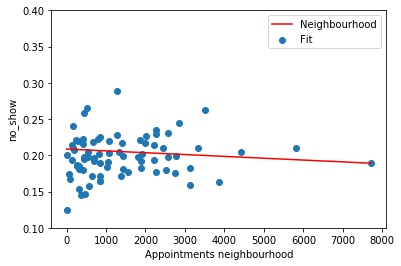

In [25]:

lin_fit(nei_data['count'].values,nei_data['rate'].values,ylim=[0.1,0.4], legend=['Neighbourhood','Fit'], xlabel='Appointments neighbourhood', ylabel = 'no_show')

This gives too much weight to small neighbourhoods. Let's repeat this, giving each neighbourhood its weight

In [26]:
data['neighbourhood_occurences'] = data.apply(lambda x:(nei_data['count'][x['Neighbourhood']] ),axis=1)
data['neighbourhood_rate'] = data.apply(lambda x:(nei_data['rate'][x['Neighbourhood']] ),axis=1)

residual: 0.000707654098747
b: [ -6.66144258e-07   2.03583615e-01]


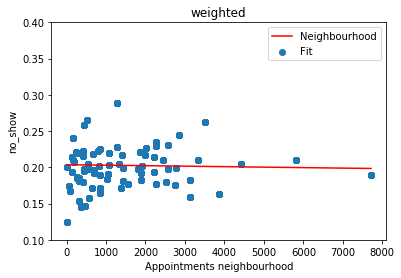

In [27]:
lin_fit(data['neighbourhood_occurences'].values,data['neighbourhood_rate'].values,ylim=[0.1,0.4],title = 'weighted', legend=['Neighbourhood','Fit'], xlabel='Appointments neighbourhood', ylabel = 'no_show')

Nothing of value here, the values may be randomally selected, saying nothing about the neighbourhood itself

As expected, there's much more variance for lower numbers.
The no_show rate doesn't change with the size increase.

There is, however, a lot of unexpected noise - meaning that the neighhbourhood is a significant factor.
We just don't know how yet

One approach would be to code for neighbourhoods, but we don't have enough data from each neighbourhood

Idealy, we would use a map to cluster neighbourhoods according to their coordinates - assuming similar socio-economic status would behave similarly.
This could be done using google maps api, but is not a viable option for now.

What we can do is use the scholarship feature to classify the neighbourhoods. 



residual: 0.00931071337793
b: [-0.02329304  0.20732962]


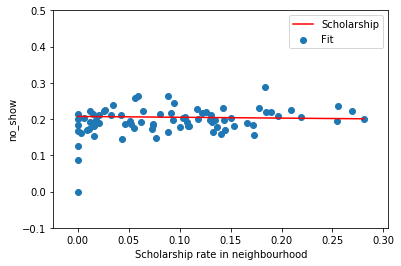

In [28]:

nei_data['scholarship'] = data.groupby('Neighbourhood')['Scholarship'].mean()
lin_fit(nei_data['scholarship'].values,nei_data['rate'].values, legend=['Scholarship','Fit'], xlabel='Scholarship rate in neighbourhood', ylabel = 'no_show')


no_show rates are the same for neighbourhoods with many scholars and those with none.


In [29]:
data.groupby('Scholarship')['no_show'].mean()

Scholarship
0    0.197898
1    0.237305
Name: no_show, dtype: float64

While scholars are more likely to miss appointments.

This must be because scholars are less abundant



In [30]:
data.groupby('Scholarship')['no_show'].count()

Scholarship
0    99521
1    10851
Name: no_show, dtype: int64

Non-scholars are 10 times as abundant.  This is why we didn't notice a difference between the neighbourhoods.

There is still some inherent difference between the Neighbourhoods, and it likely doesn't apear in the data.

I can give each of the neighbourhoods a rating according to its no_show rate


 ## PatientID

In [31]:
print('unique patients:',data['PatientId'].unique().size)

data.groupby('PatientId')['AppointmentID'].count().describe()


unique patients: 62210


count    62210.000000
mean         1.774184
std          1.770795
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         88.000000
Name: AppointmentID, dtype: float64

There are 62210 patients.

the mean number of appointments is 1.77,
some patients have up to 88 appointments.

Let's look at the consistency of various patients

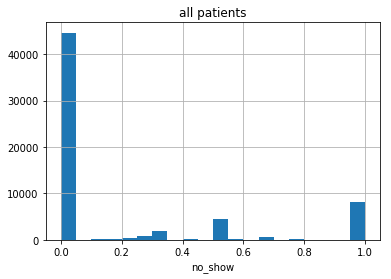

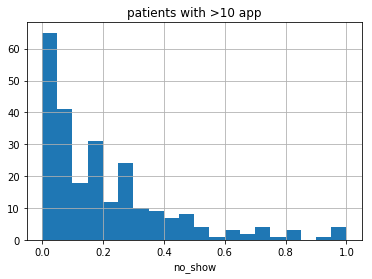

In [32]:
patient_data = data.groupby('PatientId')['Age'].count()
patient_data=patient_data.to_frame()
patient_data['rate'] = data.groupby('PatientId')['no_show'].mean()
patient_data = patient_data.sort_values('Age',ascending=False)
patient_data = patient_data.rename(index=str, columns={"Age": "count"})
patient_data[patient_data['count']>0].hist('rate',bins= 20)
plt.xlabel('no_show')
plt.title('all patients')
patient_data[patient_data['count']>10].hist('rate',bins= 20)
plt.xlabel('no_show')
plt.title('patients with >10 app')
plt.show()


Looking at patients with at least 10 appointments, a lot of them miss no or almost no appointments.  Some miss all of the appointments. But they are very consistent!

I'll add the rate and number of appointments to each patient


In [33]:


data['num_app'] = data.apply(lambda x:(patient_data['count'][x['PatientId']] ),axis=1)
data['patient_rate'] = data.apply(lambda x:(patient_data['rate'][x['PatientId']] ),axis=1)


Let's see if there's a connection between number of appointments per patient and no_show rates

residual: 0.0983797210887
b: [-0.00190828  0.20853048]


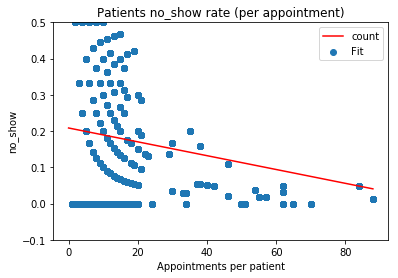

residual: 0.00770390824501
b: [-0.00298455  0.20937107]


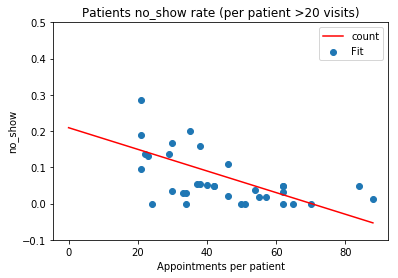

In [34]:
lin_fit(data['num_app'].values,data['patient_rate'].values,title='Patients no_show rate (per appointment)', legend = ['count','Fit'],xlabel = 'Appointments per patient', ylabel='no_show')

patient_data_freq=patient_data[patient_data['count']>20]

lin_fit(patient_data_freq['count'].values, patient_data_freq['rate'].values, deg=1,legend=['count','Fit'],xlabel='Appointments per patient', ylabel='no_show',title='Patients no_show rate (per patient >20 visits)')


Definitely a connection, with frequent patients arriving consistently

In [35]:
data[:5]

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,...,is_male,age_code,app_day_code,sch_day_code,time_diff,time_diff_code,neighbourhood_occurences,neighbourhood_rate,num_app,patient_rate
0,29872499824296.0,5642903,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,...,0,5,4,4,0,1,3875,0.162839,2,0.0
1,558997776694438.0,5642503,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,...,1,5,4,4,0,1,3875,0.162839,2,0.0
2,4262962299951.0,5642549,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,...,0,5,4,4,0,1,644,0.170807,2,0.0
3,867951213174.0,5642828,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,...,0,2,4,4,0,1,69,0.173913,2,0.5
4,8841186448183.0,5642494,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,...,0,5,4,4,0,1,3875,0.162839,1,0.0


Let's make the data more presentable!
Start by removing everything we don't need - 

'PatientId', 'ScheduledDay','AppointmentDay','Age','Neighbourhood','AppointmentID','time_diff'


In [36]:
data_clean = data.drop(columns=['PatientId', 'ScheduledDay','AppointmentDay','Age','Neighbourhood','AppointmentID', 'time_diff'])

And now to set the dummy variables
start with the ages.

The ages are grouped nicely, but remember - we need to account for age similarity.

let's 'smudge' the coding accross the groups.

this is a sort of interpolation with a gaussian

In [37]:
ages= data.groupby('age_code').count()

def code_column(data,column,smudge = False, kernel = [0.2,0.6,0.2]):
    
    dummies = pd.get_dummies(np.arange(data[column].min(),data[column].max()+1,1))
    if (smudge):
        dummies = dummies.apply(lambda x:(np.convolve(np.array(x),kernel,mode='same')))
    codes = data.apply(lambda x:(dummies[x[column]]),axis=1)
    names = {}
    for name in age_dummies.columns.values:
        names[name]=str(column)+'_'+ str(name)
        
    codes = codes.rename(names,axis=1)
    data_temp = pd.concat([data,codes],axis=1)
    return (data_temp)
        

age_dummies = pd.get_dummies(np.arange(0,9,1))
age_dummies = age_dummies.apply(lambda x:(np.convolve(np.array(x),[0.2,0.6,0.2],mode='same')))
age_dummies

,0,1,2,3,4,5,6,7,8
0,0.6,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.2,0.6,0.2,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.2,0.6,0.2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.2,0.6,0.2,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.2,0.6,0.2,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.2,0.6,0.2,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.2,0.6,0.2,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.6,0.2
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.6


In [38]:
data_clean = code_column(data_clean,'age_code',smudge=True, kernel = [0.2,0.6,0.2])
data_clean = code_column(data_clean,'app_day_code')
data_clean = code_column(data_clean,'time_diff_code',smudge=True,kernel = [0.1,0.8,0.1])
data_clean = code_column(data_clean,'sch_day_code')
data_clean = data_clean.drop(columns=['age_code','app_day_code','time_diff_code','sch_day_code'])
data_clean[:5]

,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,no_show,is_male,neighbourhood_occurences,neighbourhood_rate,...,time_diff_code_2,time_diff_code_3,time_diff_code_4,time_diff_code_5,sch_day_code_0,sch_day_code_1,sch_day_code_2,sch_day_code_3,sch_day_code_4,sch_day_code_5
0,0,1,0,0,0,0,0,0,3875,0.162839,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,3875,0.162839,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,644,0.170807,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,69,0.173913,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
4,0,1,1,0,0,0,0,0,3875,0.162839,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0


In [39]:
nei_sqrt = data_clean['neighbourhood_occurences'].apply(np.sqrt)
nei_sqrt_normal = (nei_sqrt-nei_sqrt.min())/nei_sqrt.max()
data_clean['neighbourhood_occurences']= nei_sqrt_normal
data_clean[:10]

,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,no_show,is_male,neighbourhood_occurences,neighbourhood_rate,...,time_diff_code_2,time_diff_code_3,time_diff_code_4,time_diff_code_5,sch_day_code_0,sch_day_code_1,sch_day_code_2,sch_day_code_3,sch_day_code_4,sch_day_code_5
0,0,1,0,0,0,0,0,0,0.697414,0.162839,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0.697414,0.162839,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0.277569,0.170807,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0.083197,0.173913,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
4,0,1,1,0,0,0,0,0,0.697414,0.162839,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
5,0,1,0,0,0,0,0,0,0.317641,0.171257,...,0.1,0.0,0.0,0.0,0,0,1,0,0,0
6,0,0,0,0,0,0,1,0,0.289871,0.195714,...,0.1,0.0,0.0,0.0,0,0,1,0,0,0
7,0,0,0,0,0,0,1,0,0.289871,0.195714,...,0.1,0.0,0.0,0.0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0.529680,0.229407,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0.319996,0.188902,...,0.1,0.0,0.0,0.0,0,0,1,0,0,0


## Summary


In [82]:
data[data['no_show']==1].describe()

,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,no_show,is_male,age_code,app_day_code,sch_day_code,time_diff,time_diff_code,neighbourhood_occurences,neighbourhood_rate,num_app,patient_rate
count,2.227000e+04,22270.000000,22270.000000,22270.000000,22270.000000,22270.000000,22270.000000,22270.000000,22270.0,22270.000000,22270.000000,22270.000000,22270.000000,22270.000000,22270.000000,22270.000000,22270.000000,22270.000000,22270.000000
mean,5.653057e+06,34.275438,0.115626,0.168253,0.064122,0.030310,0.019937,0.438033,1.0,0.346116,3.296902,1.861114,1.868657,15.606825,3.188190,2707.550786,0.205287,3.133857,0.690128
std,7.188714e+04,21.929480,0.319784,0.374099,0.244976,0.171442,0.155598,0.496156,0.0,0.475741,1.359144,1.389442,1.378498,15.698063,1.101444,1857.117577,0.028250,3.619579,0.293072
min,5.309683e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.085714,1.000000,0.011364
25%,5.614506e+06,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,2.000000,1.000000,1.000000,4.000000,3.000000,1396.000000,0.188902,1.000000,0.500000
50%,5.658076e+06,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,3.000000,2.000000,2.000000,11.000000,3.000000,2265.000000,0.204204,2.000000,0.666667
75%,5.703264e+06,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.000000,4.000000,3.000000,3.000000,23.000000,4.000000,3331.000000,0.221277,4.000000,1.000000
max,5.789986e+06,98.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.0,1.000000,6.000000,5.000000,5.000000,98.000000,6.000000,7713.000000,1.000000,88.000000,1.000000


In [81]:
data[data['no_show']==0].describe()

,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,no_show,is_male,age_code,app_day_code,sch_day_code,time_diff,time_diff_code,neighbourhood_occurences,neighbourhood_rate,num_app,patient_rate
count,8.810200e+04,88102.000000,88102.000000,88102.000000,88102.00000,88102.000000,88102.000000,88102.000000,88102.0,88102.000000,88102.000000,88102.000000,88102.000000,88102.000000,88102.000000,88102.000000,88102.000000,88102.000000,88102.000000
mean,5.681641e+06,37.758643,0.093937,0.203968,0.07371,0.030442,0.022667,0.290992,0.0,0.351082,3.486311,1.857143,1.848131,8.613414,2.299675,2722.233139,0.200884,3.644628,0.078328
std,6.758079e+04,23.316620,0.291742,0.402948,0.26130,0.171801,0.162546,0.454223,0.0,0.477311,1.434704,1.367302,1.378413,13.888308,1.312570,1890.889777,0.026132,7.116380,0.161899
min,5.283218e+06,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,5.646362e+06,18.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1396.000000,0.182720,1.000000,0.000000
50%,5.685765e+06,38.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2265.000000,0.198413,2.000000,0.000000
75%,5.731128e+06,56.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.0,1.000000,5.000000,3.000000,3.000000,12.000000,3.000000,3331.000000,0.215130,4.000000,0.000000
max,5.790484e+06,99.000000,1.000000,1.000000,1.00000,1.000000,4.000000,1.000000,0.0,1.000000,6.000000,5.000000,5.000000,98.000000,6.000000,7713.000000,0.289412,88.000000,0.916667


# Classification


First let's write functions to assess the ROC curve for a given classifier

In [263]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

def test_classifier(classifier ,data ,reps = 1, test_size = 0.2, exclude = [], pca = False, pca_components=0):
    pca_ = PCA(n_components=pca_components)
    
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=(['no_show']+exclude)),data['no_show'] , test_size = test_size, random_state=42)
    y_hat = np.ones(y_test.size)
    y = np.array(y_test)
    
    for seed in np.arange(0,reps,1):
        X_train, X_test, y_train, y_test = train_test_split(data_clean.drop(columns=(['no_show']+exclude)),data['no_show'] , test_size = test_size, random_state=seed)
        if pca:
            X_train = pd.DataFrame(pca_.fit_transform(X_train.values),columns=['component_'+str(x) for x in range(pca_components)])
            X_test = pd.DataFrame(pca_.fit_transform(X_test.values),columns=['component_'+str(x) for x in range(pca_components)])
        classifier.fit(y = y_train,X = X_train)
        y_hat =np.vstack([y_hat,tree.predict(X_test)])
        y = np.vstack([y,y_test])
    return roc_stats(y_hat, y)
    
    
def roc_stats(y_hat,y):
    specificity = np.array([])
    sensitivity = np.array([])
    for i,row in enumerate(y_hat):
        TN = ((y_hat[i] == 0) * (y[i] == 0)).sum()
        FN = ((y_hat[i] == 0) * (y[i] == 1)).sum()
        TP = ((y_hat[i] == 1) * (y[i] == 1)).sum()
        FP = ((y_hat[i] == 1) * (y[i] == 0)).sum()    
        specificity = np.append(specificity, TN / (TN + FP))
        sensitivity = np.append(sensitivity,  TP / (TP + FN))    
        #print('\nTN: '+str(TN)+'  FN: '+str(FN)+'  TP: '+str(TP)+'    FP: '+str(FP))
    return [specificity,sensitivity]    
        
        
def roc_graph(specificity,sensitivity):
    fig, ax = plt.subplots()
    ax.scatter(1-specificity,sensitivity)
    plt.ylabel('sensitivity')
    plt.xlabel('1-specificity')
    plt.plot([0,1],[0,1])
    plt.title('ROC')
    for i, txt in enumerate(specificity):
        ax.annotate(i, ((1-specificity)[i],sensitivity[i]))
    
    plt.show()
    



## Decision Tree

A decision tree isn't the best method for the way I've designed the features, but it may achieve some results

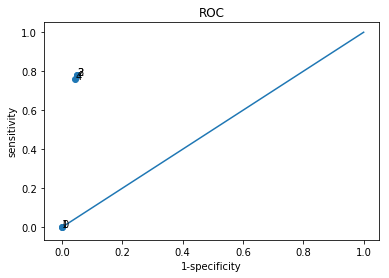

Feature importance:
Scholarship : 0.0
None
Hipertension : 0.0
None
Diabetes : 0.0
None
Alcoholism : 0.0
None
Handcap : 0.0
None
SMS_received : 0.0
None
no_show : 0.0
None
is_male : 0.0
None
neighbourhood_occurences : 0.0
None
neighbourhood_rate : 0.00286450858323
None
num_app : 0.927936583508
None
patient_rate : 0.0
None
age_code_0 : 0.0
None
age_code_1 : 0.0
None
age_code_2 : 0.0
None
age_code_3 : 0.0
None
age_code_4 : 0.0
None
age_code_5 : 0.0
None
app_day_code_0 : 0.0
None
app_day_code_1 : 0.0
None
app_day_code_2 : 0.0
None
app_day_code_3 : 0.0
None
app_day_code_4 : 0.0
None
app_day_code_5 : 0.0682167843187
None
time_diff_code_0 : 0.0
None
time_diff_code_1 : 0.0
None
time_diff_code_2 : 0.0
None
time_diff_code_3 : 0.000982123589542
None
time_diff_code_4 : 0.0
None
time_diff_code_5 : 0.0
None
sch_day_code_0 : 0.0
None
sch_day_code_1 : 0.0
None
sch_day_code_2 : 0.0
None
sch_day_code_3 : 0.0
None
sch_day_code_4 : 0.0
None


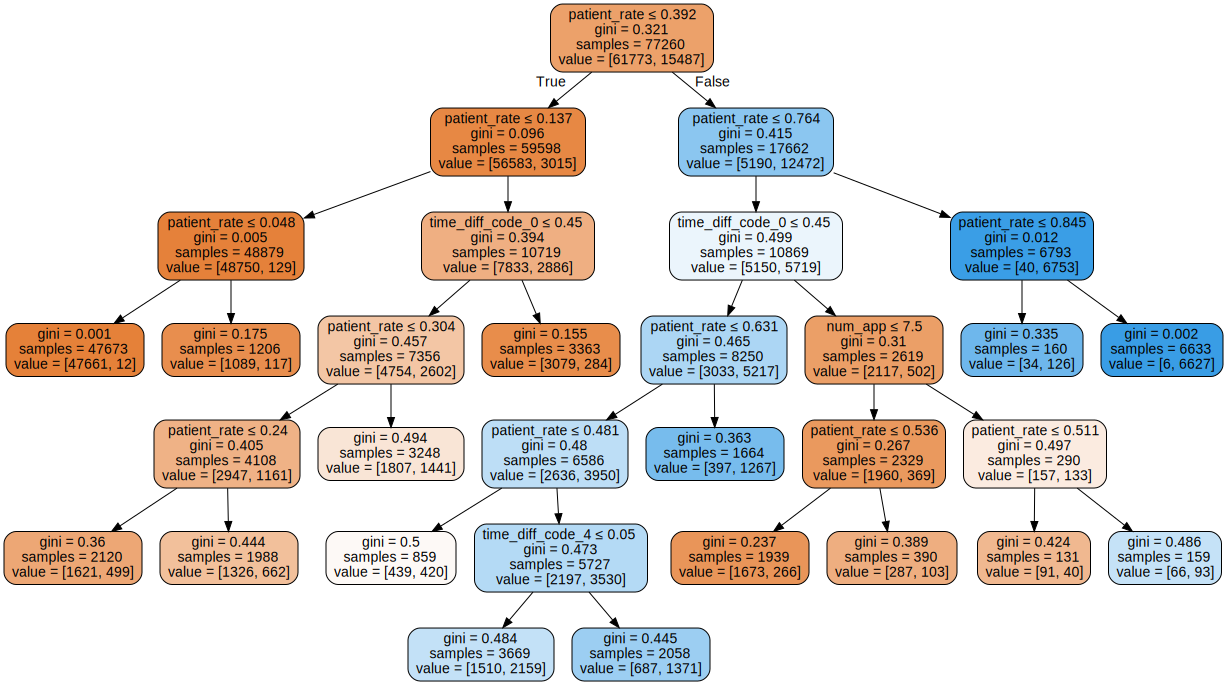

In [305]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
impurities = [0.2,0.25,0.001,0.002,0.0001]
excludes = []
specificities = np.array([])
sensitivities = np.array([])
for impurity in impurities:
    tree = DecisionTreeClassifier(min_impurity_decrease = impurity)
    results = test_classifier(tree,data_clean,test_size = 0.3,reps = 1, exclude = excludes)

    specificities = np.append(specificities, results[0][1])
    sensitivities = np.append(sensitivities, results[1][1])

roc_graph(specificities,sensitivities)
dot_data = export_graphviz(tree,out_file = None,feature_names= data_clean.drop(columns=excludes).columns.values[1::],
                         filled=True, rounded=True,  
                         special_characters=True)  
print('Feature importance:')
for a,b in zip(tree.feature_importances_, data_clean.columns.values):
    print(print(str(b)+' : '+str(a)))
graph = graphviz.Source(dot_data)  
graph

The decision tree doesn't play well with my dummy variable tricks,

also for a decision tree it would've been best to leave factors like age as they were, instead of coding them.
This would've been done by the CART algorithm anyway, as it partitions the  continuous factors

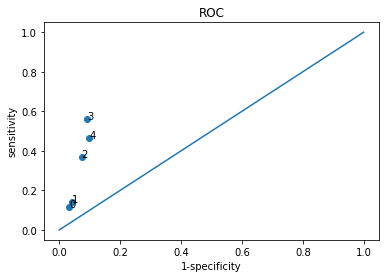

Feature importance:

0 : 0.0
1 : 0.256971229751
2 : 0.0979709455266
3 : 0.0
4 : 0.0296254816689
5 : 0.0
6 : 0.0
7 : 0.0
8 : 0.14244008711
9 : 0.0474691200482
10 : 0.374363426921
11 : 0.0511597089737


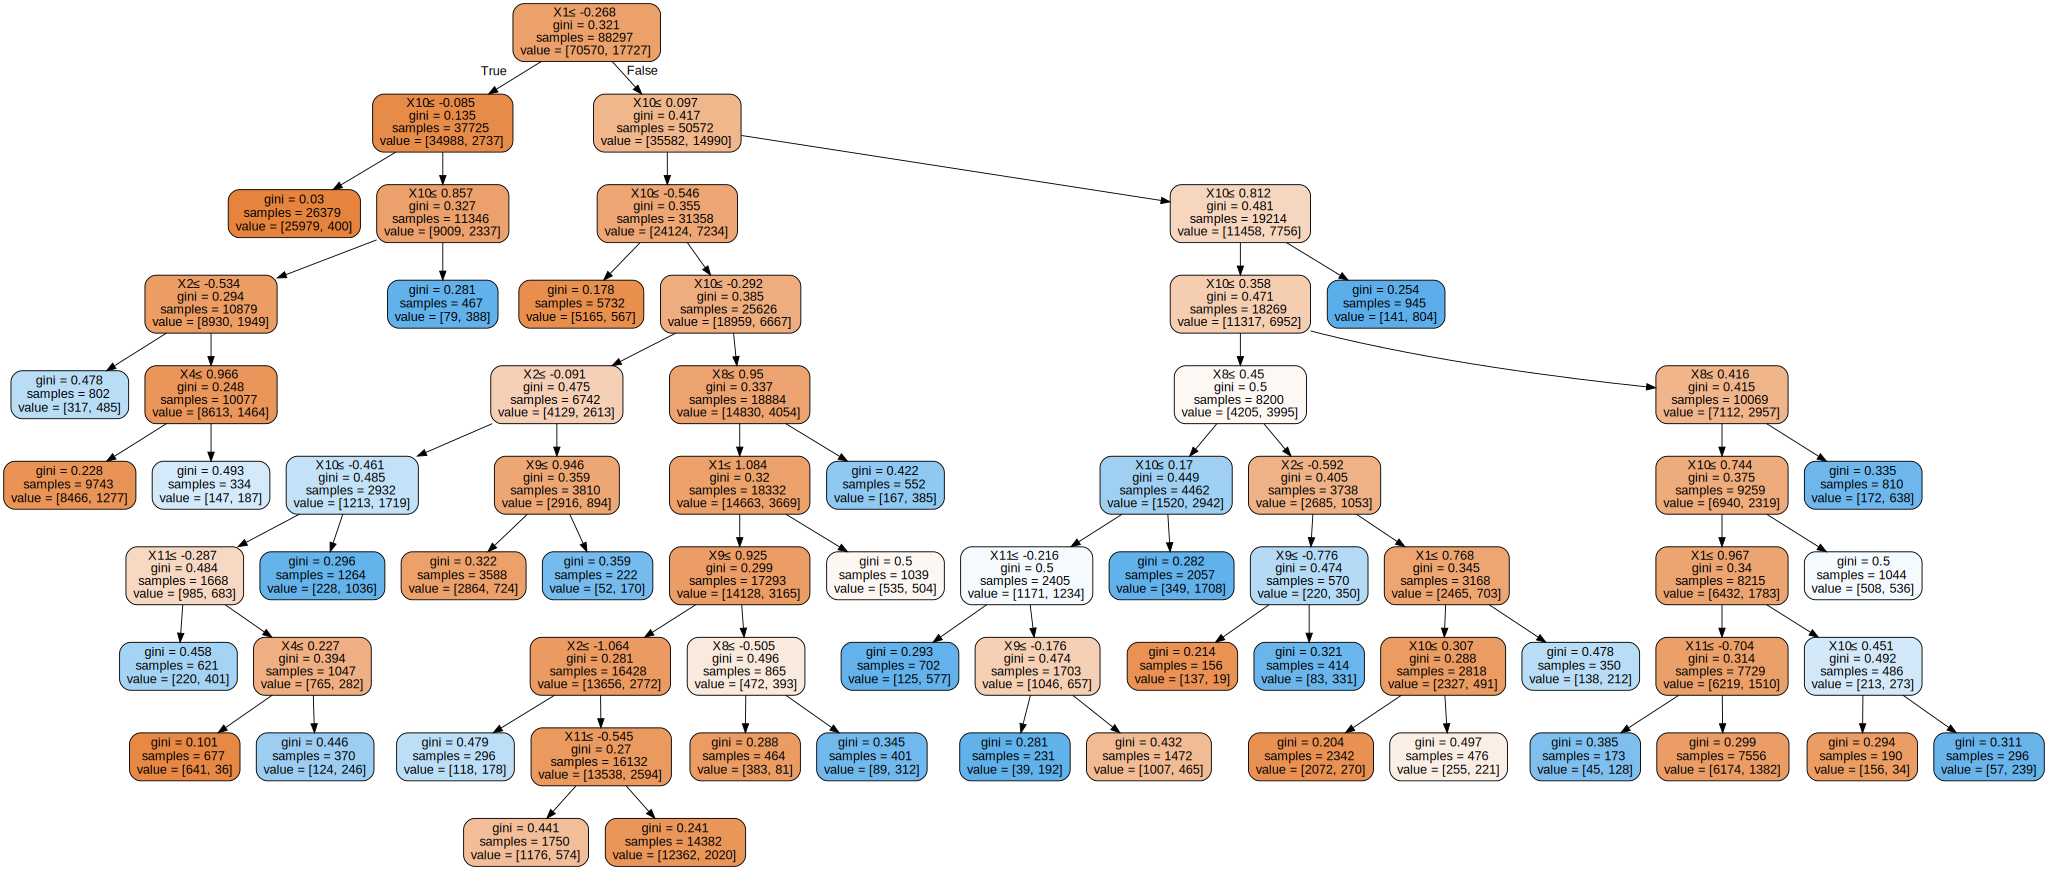

In [306]:

specificities = np.array([])
sensitivities = np.array([])
tree = DecisionTreeClassifier(min_impurity_decrease = 0.001)
for components in np.arange(8,13,1):
    results = test_classifier(tree , data_clean , test_size = 0.2, reps = 1, exclude = excludes, pca=True, pca_components = components)
    
    specificities = np.append(specificities, results[0][1])
    sensitivities = np.append(sensitivities, results[1][1])

roc_graph(specificities,sensitivities)

dot_data = export_graphviz(tree,out_file = None,
                         filled=True, rounded=True,  
                         special_characters=True)  

print('Feature importance:\n')
for i,a in enumerate(tree.feature_importances_):
    print(str(i)+' : '+str(a))
graph = graphviz.Source(dot_data)  
graph
